In [1]:
from defillama2alpha import DefiLlama
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter, FuncFormatter

pd.set_option('display.max_columns', 15)
pd.set_option('display.max_rows', 50)
pd.options.display.float_format = '{:,.4f}'.format

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)
plt.style.use("fivethirtyeight")

# Makes graphs crisp. Only use if you don't have a lot of points/lines on your graph.
%config InlineBackend.figure_formats = ['svg', 'retina'] # use svg, then retina if svg is not supported

In [2]:
def human_format_dollar_or_num(dollar=False, decimals=0):
    """ 
    Return a function for formatting matplot axis numbers human friendly. 

    Parameters
    ----------
    dollar: logical
        If True, will add $ in front of the numbers.
    decimals: int
        Number of decimals to display.
    """

    base_fmt = '%.{}f%s'.format(decimals)
    if dollar:
        base_fmt = '$' + base_fmt

    def human_format(num, pos): # pos is necessary as it'll be used by matplotlib
        magnitude = 0
        while abs(num) >= 1000:
            magnitude += 1
            num /= 1000.0
        return base_fmt % (num, ['', 'K', 'M', 'B', 'T', 'P'][magnitude])
    return human_format

## Create a DefiLlama instance

In [3]:
obj = DefiLlama()

## Get latest yields for all pools, along with other info

In [4]:
df = obj.get_pools_yields() # See https://defillama.com/yields for the meaning of columns.
print(df.shape)
df.head() 

(11181, 30)


,chain,project,symbol,tvlUsd,apyBase,apyReward,apy,...,apyMean30d,volumeUsd1d,volumeUsd7d,apyBaseInception,predictedClass,predictedProbability,binnedConfidence
0,Ethereum,lido,STETH,10352985856,5.0000,NaN,5.0000,...,5.3184,NaN,NaN,NaN,Down,53.0000,1.0000
1,Tron,justlend,BTC,3086944995,0.0001,0.0237,0.0238,...,0.0272,NaN,NaN,NaN,Stable/Up,74.0000,2.0000
2,Ethereum,makerdao,USDC,2934016822,NaN,NaN,0.0000,...,0.0000,NaN,NaN,NaN,None,NaN,NaN
3,Ethereum,coinbase-wrapped-staked-eth,CBETH,2055527737,4.1504,NaN,4.1504,...,4.5367,NaN,NaN,NaN,Stable/Up,64.0000,2.0000
4,Ethereum,aave-v2,STETH,1766376325,0.0000,NaN,0.0000,...,0.0000,NaN,NaN,NaN,None,NaN,NaN


In [5]:
df.columns

Index(['chain', 'project', 'symbol', 'tvlUsd', 'apyBase', 'apyReward', 'apy',
       'rewardTokens', 'pool', 'apyPct1D', 'apyPct7D', 'apyPct30D',
       'stablecoin', 'ilRisk', 'exposure', 'poolMeta', 'mu', 'sigma', 'count',
       'outlier', 'underlyingTokens', 'il7d', 'apyBase7d', 'apyMean30d',
       'volumeUsd1d', 'volumeUsd7d', 'apyBaseInception', 'predictedClass',
       'predictedProbability', 'binnedConfidence'],
      dtype='object')

In [6]:
# let's look at TriCrypto pools on Ethereum and Arbitrum, discarding outlier pools (with extreme APYs and usually low TVL)
is_true = (df.symbol.isin(['yvCurve-Tricrypto', 'USDT-WBTC-WETH', 'WBTC-WETH-USDC']) & 
           df.chain.isin(['Ethereum', 'Arbitrum']) & 
           (~df.outlier))

# I guess columns `mu` and `sigma` are mean and standard deviation of past APYs over `count` many APYs.
# `apyPct7D` is pct change in APY for the last 7 days; `apyPct30D` is NaN for all records.
# `predictedClass` is DeFiLlama's prediction on which way the APY is heading to. 
cols = ['chain', 'project', 'symbol', 'tvlUsd', 'apyBase', 'apyReward', 'apy', 'apyPct7D', 
        'mu', 'sigma', 'count', 'predictedClass', 'predictedProbability']
df.loc[is_true, cols].sort_values('apy', ascending=False)

,chain,project,symbol,tvlUsd,apyBase,apyReward,apy,apyPct7D,mu,sigma,count,predictedClass,predictedProbability
183,Ethereum,concentrator,USDT-WBTC-WETH,31651097,NaN,NaN,12.4000,-6.2800,18.6551,0.5658,308,Down,81.0000
43,Ethereum,convex-finance,USDT-WBTC-WETH,188185903,0.6417,9.7561,10.3977,-2.3678,13.6340,0.3347,354,Stable/Up,68.0000
202,Arbitrum,curve,USDT-WBTC-WETH,28416185,1.3589,8.0822,9.4411,-20.9370,2.9842,0.1844,367,Down,62.0000
957,Arbitrum,balancer-v2,WBTC-WETH-USDC,3374028,5.3533,2.4173,7.7706,-6.9904,13.5810,0.2974,410,Stable/Up,78.0000
37,Ethereum,curve,USDT-WBTC-WETH,204363300,0.6417,5.7593,6.4009,-1.8969,8.3002,0.1709,411,Stable/Up,87.0000
5532,Arbitrum,pickle,USDT-WBTC-WETH,136804,NaN,NaN,2.0775,-0.4439,7.0369,0.2250,322,Stable/Up,84.0000
3383,Ethereum,curve,USDT-WBTC-WETH,384051,0.5525,0.0000,0.5525,0.2375,0.5973,0.0413,367,Down,56.0000
9267,Ethereum,convex-finance,USDT-WBTC-WETH,22077,0.5525,0.0000,0.5525,0.2375,0.7071,0.0539,243,Down,78.0000


In [7]:
# let's find multi-sided stablecoin pools without IL and with TVL > $1M on Arbitrum
is_true = (df.chain == 'Arbitrum') & df.stablecoin & (df.ilRisk == 'no') & (df.exposure == 'multi') & (df.tvlUsd > 1e6) & (~df.outlier)
df.loc[is_true, cols].sort_values('apy', ascending=False)

,chain,project,symbol,tvlUsd,apyBase,apyReward,apy,apyPct7D,mu,sigma,count,predictedClass,predictedProbability
1826,Arbitrum,kyberswap-elastic,MAI-GDAI,1164221,3.0026,27.7545,30.7570,-11.3152,33.9821,0.4772,23,Down,58.0000
1155,Arbitrum,3xcalibur,DAI-USDC,2515573,NaN,20.4701,20.4701,-4.8328,14.5128,0.4055,119,Down,73.0000
1501,Arbitrum,3xcalibur,USDT-USDC,1637493,NaN,19.3400,19.3400,-5.9156,27.9325,0.5254,74,Stable/Up,60.0000
1915,Arbitrum,camelot,MIM-USDC,1072373,0.6109,15.4220,16.0329,-5.2872,11.0700,0.3430,43,Down,64.0000
1308,Arbitrum,kyberswap-elastic,USDT-USDC,2033447,10.1600,1.3938,11.5538,-25.4442,8.2048,0.5146,142,Down,74.0000
936,Arbitrum,beefy,MIM-USDC-USDT,3496154,NaN,NaN,10.5048,-0.7696,10.8631,0.1960,411,Down,63.0000
1446,Arbitrum,uniswap-v3,DAI-USDC,1736970,5.9348,NaN,5.9348,-9.7872,22.1616,0.7099,28,Stable/Up,89.0000
1161,Arbitrum,beefy,USDT-USDC,2491944,NaN,NaN,4.8691,-21.4777,5.0195,0.1622,411,Stable/Up,57.0000
629,Arbitrum,camelot,USDT-USDC,5888194,2.1341,2.1533,4.2874,-18.5887,14.3569,0.5279,43,Stable/Up,82.0000
1012,Arbitrum,camelot,DAI-USDC,3058331,0.4777,3.6050,4.0828,-2.2062,7.7821,0.6505,43,Stable/Up,52.0000


## Get historical APY and TVL of a pool

In [8]:
# get pool ids
dat = obj.get_pools_yields()
pool_ids = dat.pool
pool_ids

0        747c1d2a-c668-4682-b9f9-296708a3dd90
1        71418c17-d2aa-4eff-b68a-806fff9ec951
2        051c1a54-df05-4bc4-9d73-c17508acae23
3        0f45d730-b279-4629-8e11-ccb5cc3038b4
4        0e458a5b-fd99-4667-8706-dd938934cb0c
                         ...                 
11176    692a48e3-d69a-4c98-aec5-ecea07c0c7a1
11177    f854b02a-478f-4870-a44a-b081f3733250
11178    7b443ea9-82e5-4e75-984a-6ae3a4efdffa
11179    0e461c71-5733-42ca-a2bf-6c9900f0851d
11180    38a072db-a93a-4de9-a831-46fca47805fd
Name: pool, Length: 11181, dtype: object

In [9]:
pool_id = pool_ids[10]
meta = dat.loc[dat.pool == pool_id, ['chain', 'project', 'symbol']]
meta

,chain,project,symbol
10,Ethereum,makerdao,WSTETH


In [10]:
df = obj.get_pool_hist_apy(pool_id)
df.head()

,tvlUsd,apy,apyBase,apyReward,il7d,apyBase7d
date,,,,,,
2022-10-26 00:00:00+00:00,"231,226,706.0000",0.0000,NaN,NaN,NaN,NaN
2022-10-27 00:00:00+00:00,"224,185,354.0000",0.0000,NaN,NaN,NaN,NaN
2022-10-28 00:00:00+00:00,"230,009,721.0000",0.0000,NaN,NaN,NaN,NaN
2022-10-29 00:00:00+00:00,"237,464,145.0000",0.0000,NaN,NaN,NaN,NaN
2022-10-30 00:00:00+00:00,"233,875,155.0000",0.0000,NaN,NaN,NaN,NaN


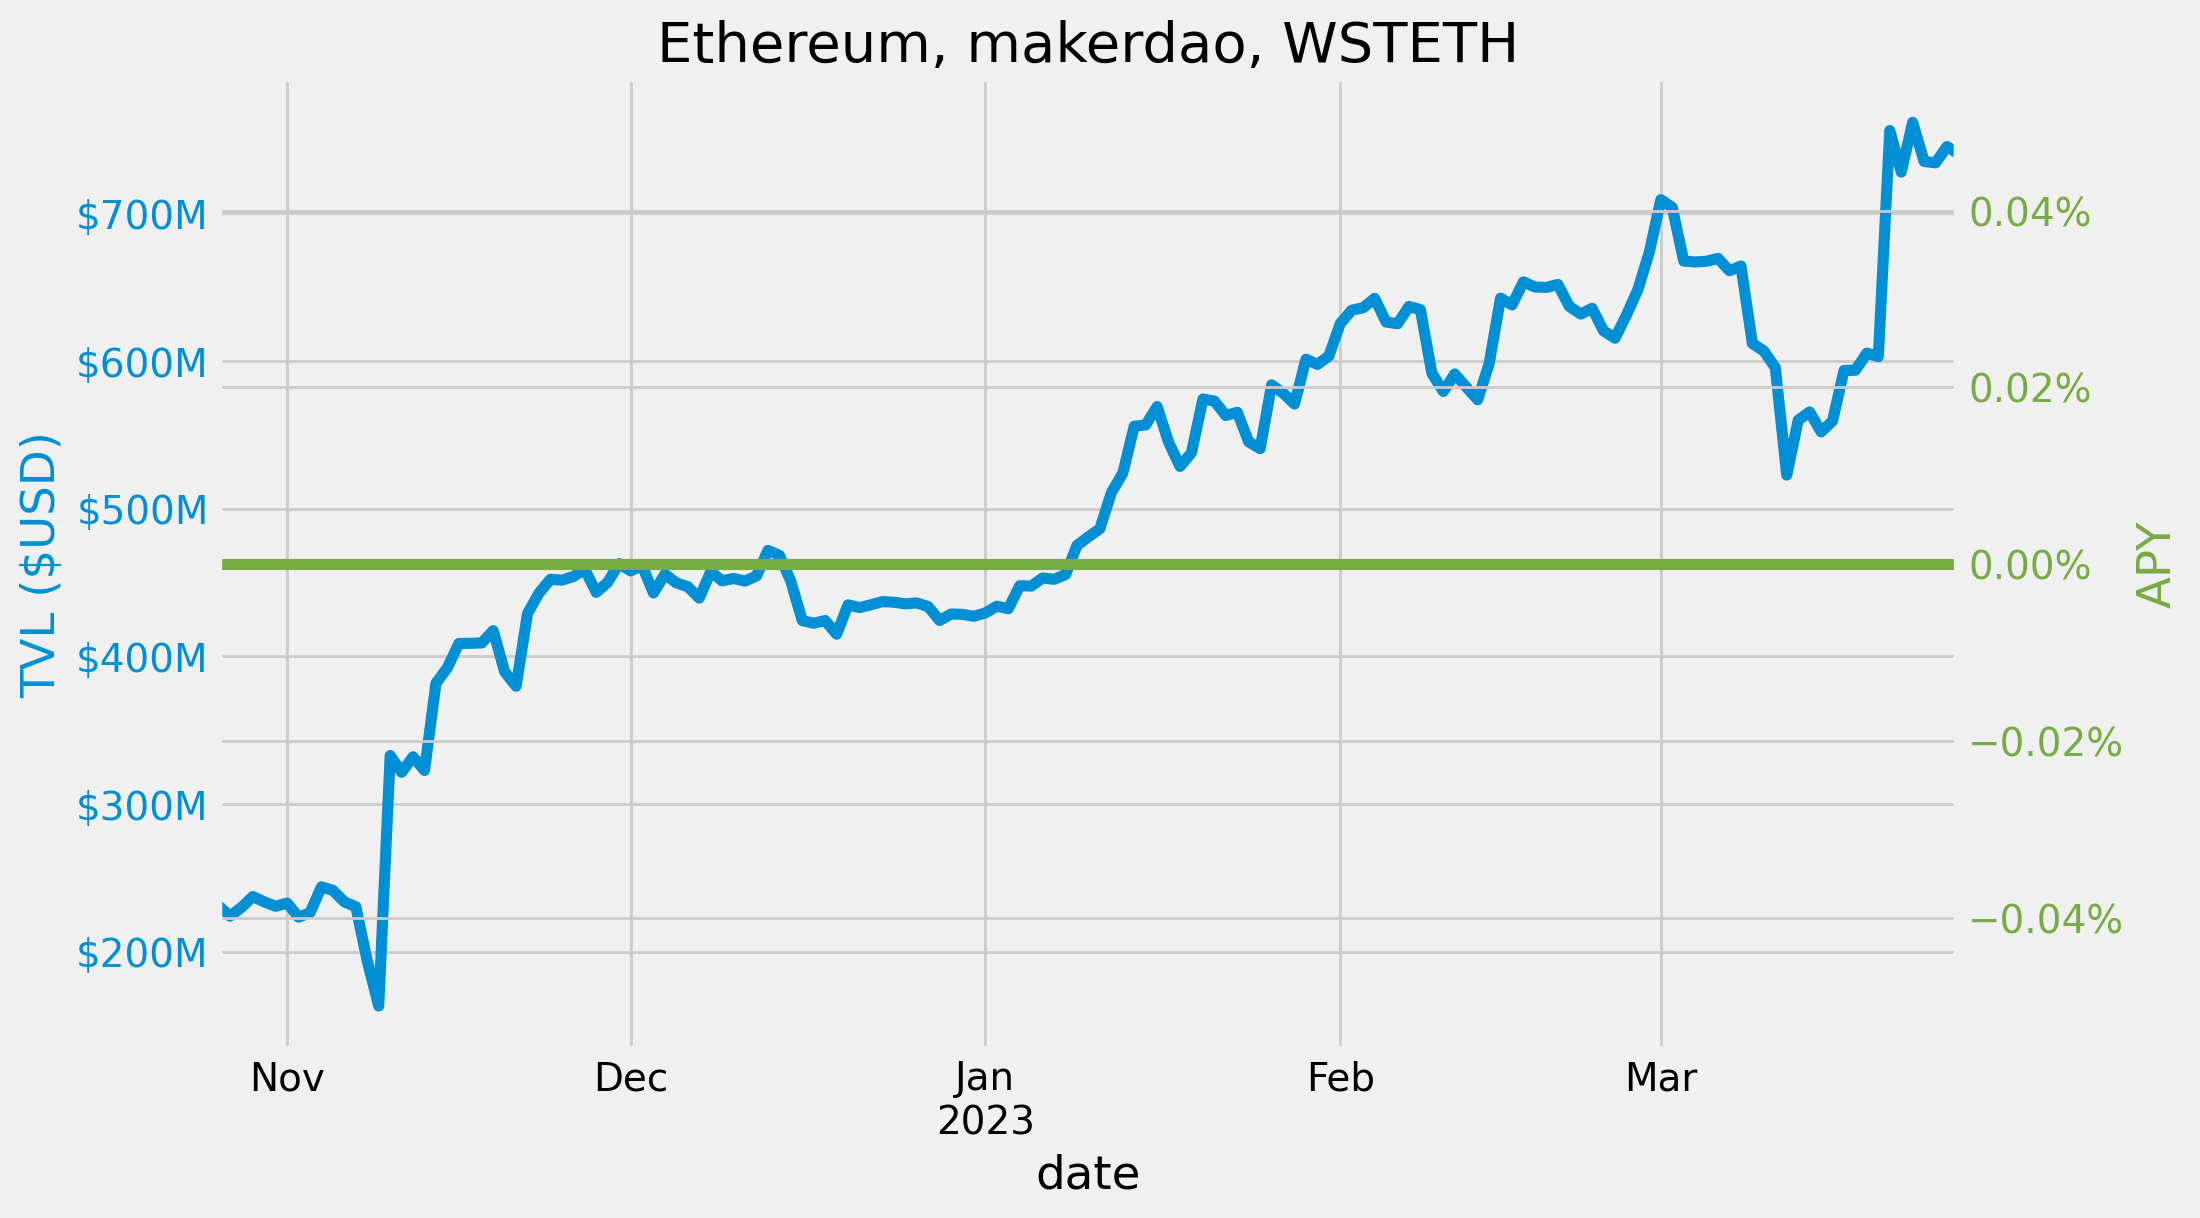

In [11]:
# plot both TVL and APY over time to see their relationships. 
ax1 = df.tvlUsd.plot()
dollar_formatter = FuncFormatter(human_format_dollar_or_num(dollar=True, decimals=0))
ax1.yaxis.set_major_formatter(dollar_formatter)
for tl in ax1.get_yticklabels():
    tl.set_color('#008FD5')
ax1.set_ylabel('TVL ($USD)', color='#008FD5')

ax2 = ax1.twinx()
ax2.plot(df.index, df.apy, color='#77AB43')
ax2.yaxis.set_major_formatter(PercentFormatter(decimals=2))
for tl in ax2.get_yticklabels():
    tl.set_color('#77AB43')
ax2.set_ylabel('APY', color='#77AB43')

fig_tit = ', '.join(meta.values.tolist()[0])
plt.title(fig_tit);    